In [13]:
import torch
from torch import nn

torch.__version__

'2.7.1+cu126'

In [14]:
# Setup device-agnostic code
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [16]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [18]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

In [19]:
# Use ImageFolder to create dataset(s)
import os
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=test_transforms)

NUM_WORKERS = os.cpu_count() # number of workers to use for data loading
assert NUM_WORKERS is not None

train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             shuffle=False,
                             num_workers=NUM_WORKERS)   

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [20]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [38]:
from torchinfo import summary
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=3).to(device)
summary(model, input_size=(1, 3, 64, 64), device=device) # batch size of 1, 3 channels (RGB), 224x224 image size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [22]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [23]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [24]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

/home/mandzakjoshua/scratch/PyTorchSummer2025/lesson_4/.lesson_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:01<00:20,  1.07s/it]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1375 | test_acc: 0.2604


 10%|█         | 2/20 [00:01<00:17,  1.04it/s]

Epoch: 2 | train_loss: 1.0829 | train_acc: 0.4258 | test_loss: 1.1671 | test_acc: 0.1979


 15%|█▌        | 3/20 [00:02<00:15,  1.09it/s]

Epoch: 3 | train_loss: 1.1211 | train_acc: 0.2930 | test_loss: 1.1731 | test_acc: 0.1979


 20%|██        | 4/20 [00:03<00:14,  1.11it/s]

Epoch: 4 | train_loss: 1.0958 | train_acc: 0.4141 | test_loss: 1.1404 | test_acc: 0.1979


 25%|██▌       | 5/20 [00:04<00:13,  1.12it/s]

Epoch: 5 | train_loss: 1.0938 | train_acc: 0.2930 | test_loss: 1.1439 | test_acc: 0.1979


 30%|███       | 6/20 [00:05<00:12,  1.14it/s]

Epoch: 6 | train_loss: 1.0947 | train_acc: 0.3164 | test_loss: 1.1479 | test_acc: 0.2604


 35%|███▌      | 7/20 [00:06<00:11,  1.13it/s]

Epoch: 7 | train_loss: 1.1142 | train_acc: 0.3477 | test_loss: 1.1337 | test_acc: 0.2396


 40%|████      | 8/20 [00:07<00:10,  1.11it/s]

Epoch: 8 | train_loss: 1.0940 | train_acc: 0.3281 | test_loss: 1.0949 | test_acc: 0.2292


 45%|████▌     | 9/20 [00:08<00:10,  1.09it/s]

Epoch: 9 | train_loss: 1.0675 | train_acc: 0.5000 | test_loss: 1.0645 | test_acc: 0.5549


 50%|█████     | 10/20 [00:09<00:09,  1.11it/s]

Epoch: 10 | train_loss: 1.0485 | train_acc: 0.4844 | test_loss: 1.0299 | test_acc: 0.5644


 55%|█████▌    | 11/20 [00:09<00:08,  1.12it/s]

Epoch: 11 | train_loss: 1.0387 | train_acc: 0.3867 | test_loss: 0.9961 | test_acc: 0.4934


 60%|██████    | 12/20 [00:10<00:07,  1.13it/s]

Epoch: 12 | train_loss: 1.0104 | train_acc: 0.5312 | test_loss: 0.9806 | test_acc: 0.5038


 65%|██████▌   | 13/20 [00:11<00:06,  1.13it/s]

Epoch: 13 | train_loss: 1.0502 | train_acc: 0.4648 | test_loss: 1.0688 | test_acc: 0.3314


 70%|███████   | 14/20 [00:12<00:05,  1.10it/s]

Epoch: 14 | train_loss: 0.9343 | train_acc: 0.5820 | test_loss: 0.9569 | test_acc: 0.3722


 75%|███████▌  | 15/20 [00:13<00:04,  1.12it/s]

Epoch: 15 | train_loss: 0.9659 | train_acc: 0.4805 | test_loss: 0.9392 | test_acc: 0.4744


 80%|████████  | 16/20 [00:14<00:03,  1.13it/s]

Epoch: 16 | train_loss: 0.9617 | train_acc: 0.4883 | test_loss: 0.9805 | test_acc: 0.4337


 85%|████████▌ | 17/20 [00:15<00:02,  1.12it/s]

Epoch: 17 | train_loss: 0.9693 | train_acc: 0.5781 | test_loss: 0.9995 | test_acc: 0.3428


 90%|█████████ | 18/20 [00:16<00:01,  1.11it/s]

Epoch: 18 | train_loss: 0.9949 | train_acc: 0.4453 | test_loss: 0.9928 | test_acc: 0.3532


 95%|█████████▌| 19/20 [00:17<00:00,  1.12it/s]

Epoch: 19 | train_loss: 0.9646 | train_acc: 0.4648 | test_loss: 0.9375 | test_acc: 0.4943


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]

Epoch: 20 | train_loss: 1.0104 | train_acc: 0.4883 | test_loss: 0.9361 | test_acc: 0.5644
Total training time: 17.985 seconds


In [26]:
def plot_losses(train_losses, test_losses) -> None:
    """
    Plots training and test losses.
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title("Losses over epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [27]:
def plot_accuracies(train_accuracies, test_accuracies) -> None:
    """
    Plots training and test accuracies.
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.title("Accuracies over epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

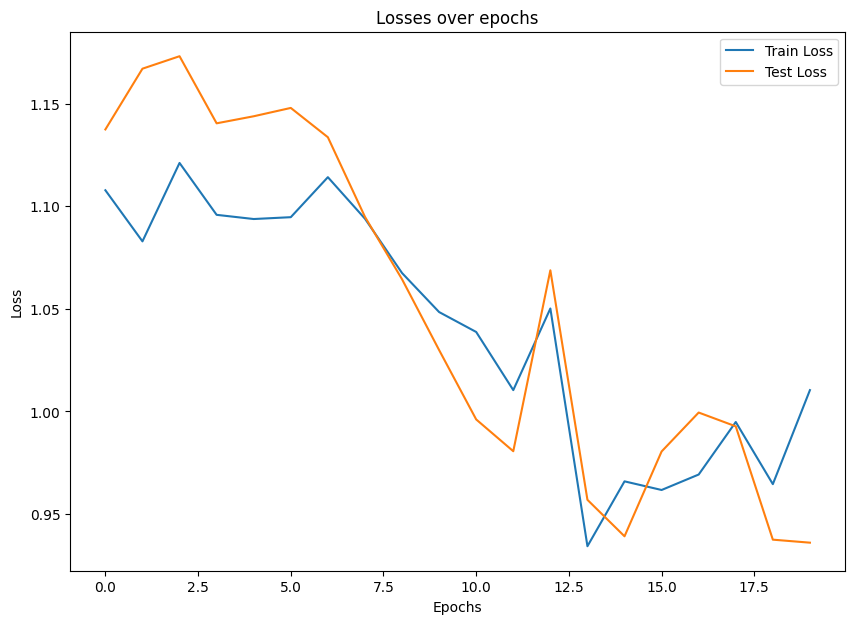

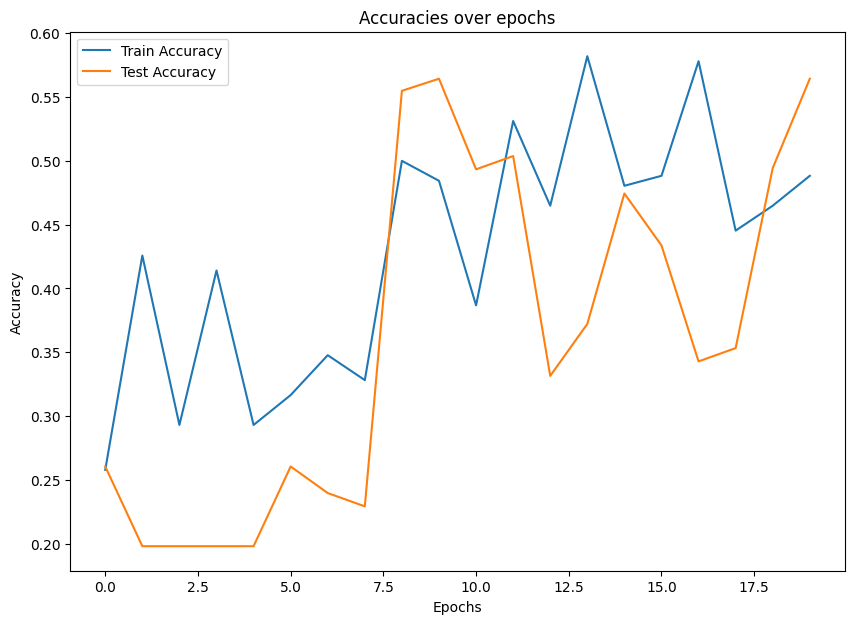

In [28]:
plot_losses(model_0_results["train_loss"], model_0_results["test_loss"])
plot_accuracies(model_0_results["train_acc"], model_0_results["test_acc"])

In [29]:
# show some test images and their predictions
import matplotlib.pyplot as plt

def plot_predictions(model: torch.nn.Module,
                     data: torch.utils.data.Dataset,
                     class_names: list,
                     num_images: int = 9) -> None:
    """
    Plots model predictions on a sample of images from a dataset.
    """
    # seed random number generator for reproducibility
    torch.manual_seed(42)
    # Set model to eval mode
    model.eval()
    
    # Get a sample of images and labels
    images, labels = next(iter(DataLoader(data, batch_size=num_images, shuffle=True)))
    
    # Send images to target device
    images = images.to(device)
    
    # Make predictions
    with torch.inference_mode():
        preds = model(images)
        preds = preds.argmax(dim=1)
    
    # Plot the images and predictions
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        plt.title(f"Predicted: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis(False)
    plt.tight_layout()
    plt.show()

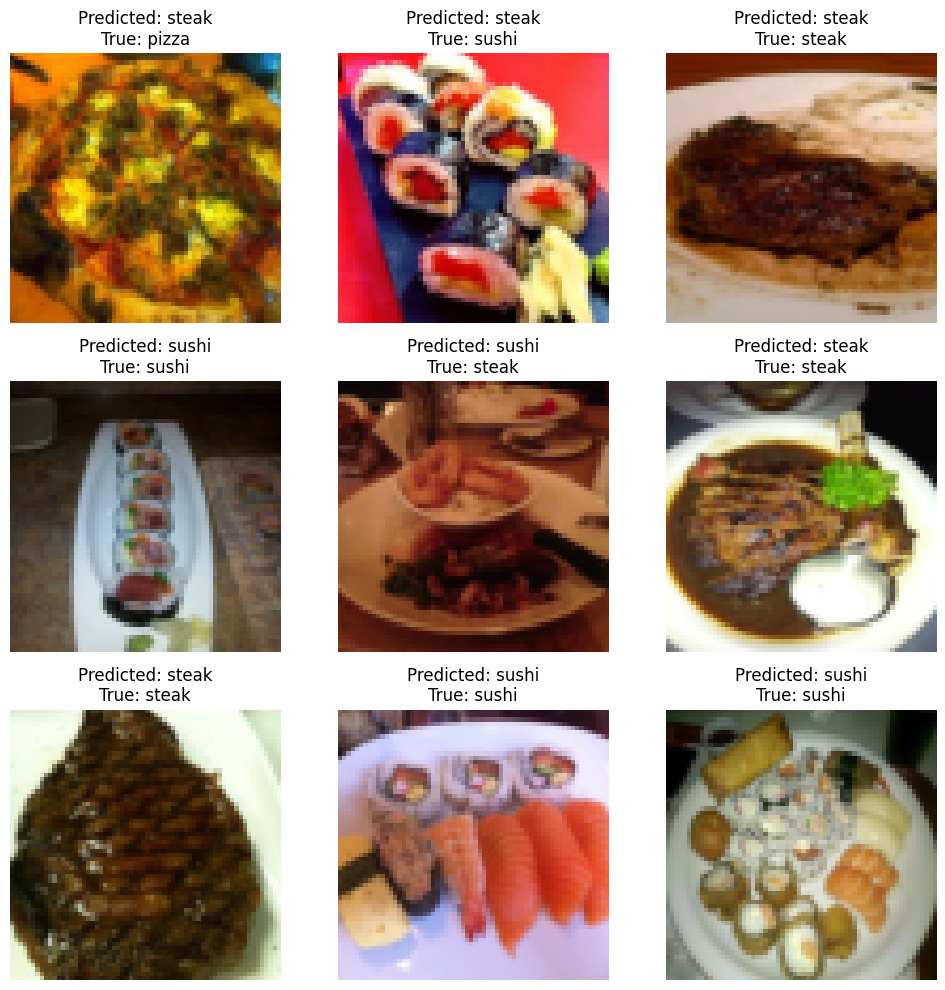

In [30]:
# show the test images and their predictions
plot_predictions(model=model_0,
                 data=test_data,
                 class_names=test_data.classes,
                 num_images=9)

In [31]:
# try a resnet18 model
from torchvision import models
# Create a ResNet18 model
model_1 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
# Change the final layer to match our number of classes
model_1.fc = nn.Linear(in_features=model_1.fc.in_features,
                          out_features=len(train_data.classes)).to(device)

# Retrain the model
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.0001)
# Start the timer
start_time = timer()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  5%|▌         | 1/20 [00:01<00:24,  1.28s/it]

Epoch: 1 | train_loss: 1.2046 | train_acc: 0.3086 | test_loss: 1.0008 | test_acc: 0.4650


 10%|█         | 2/20 [00:02<00:18,  1.02s/it]

Epoch: 2 | train_loss: 0.7578 | train_acc: 0.6133 | test_loss: 0.8107 | test_acc: 0.5985


 15%|█▌        | 3/20 [00:02<00:15,  1.06it/s]

Epoch: 3 | train_loss: 0.5649 | train_acc: 0.8438 | test_loss: 0.7907 | test_acc: 0.6496


 20%|██        | 4/20 [00:03<00:14,  1.09it/s]

Epoch: 4 | train_loss: 0.5955 | train_acc: 0.7148 | test_loss: 0.6917 | test_acc: 0.6714


 25%|██▌       | 5/20 [00:04<00:13,  1.10it/s]

Epoch: 5 | train_loss: 0.4869 | train_acc: 0.8633 | test_loss: 0.6615 | test_acc: 0.7017


 30%|███       | 6/20 [00:05<00:13,  1.03it/s]

Epoch: 6 | train_loss: 0.5253 | train_acc: 0.7656 | test_loss: 0.5774 | test_acc: 0.7121


 35%|███▌      | 7/20 [00:06<00:12,  1.03it/s]

Epoch: 7 | train_loss: 0.4181 | train_acc: 0.8867 | test_loss: 0.6196 | test_acc: 0.7320


 40%|████      | 8/20 [00:07<00:11,  1.05it/s]

Epoch: 8 | train_loss: 0.4478 | train_acc: 0.7812 | test_loss: 0.5872 | test_acc: 0.7623


 45%|████▌     | 9/20 [00:08<00:10,  1.08it/s]

Epoch: 9 | train_loss: 0.4187 | train_acc: 0.7578 | test_loss: 0.6680 | test_acc: 0.7528


 50%|█████     | 10/20 [00:09<00:09,  1.10it/s]

Epoch: 10 | train_loss: 0.3562 | train_acc: 0.8008 | test_loss: 0.7317 | test_acc: 0.7027


 55%|█████▌    | 11/20 [00:10<00:08,  1.12it/s]

Epoch: 11 | train_loss: 0.3407 | train_acc: 0.7969 | test_loss: 0.6793 | test_acc: 0.7017


 60%|██████    | 12/20 [00:11<00:07,  1.13it/s]

Epoch: 12 | train_loss: 0.3760 | train_acc: 0.8008 | test_loss: 0.7289 | test_acc: 0.6818


 65%|██████▌   | 13/20 [00:12<00:06,  1.14it/s]

Epoch: 13 | train_loss: 0.4453 | train_acc: 0.7812 | test_loss: 0.6626 | test_acc: 0.6913


 70%|███████   | 14/20 [00:12<00:05,  1.14it/s]

Epoch: 14 | train_loss: 0.2514 | train_acc: 0.9570 | test_loss: 0.7787 | test_acc: 0.6809


 75%|███████▌  | 15/20 [00:13<00:04,  1.15it/s]

Epoch: 15 | train_loss: 0.3221 | train_acc: 0.8320 | test_loss: 0.7638 | test_acc: 0.6193


 80%|████████  | 16/20 [00:14<00:03,  1.15it/s]

Epoch: 16 | train_loss: 0.2539 | train_acc: 0.9414 | test_loss: 0.7380 | test_acc: 0.6600


 85%|████████▌ | 17/20 [00:15<00:02,  1.16it/s]

Epoch: 17 | train_loss: 0.3053 | train_acc: 0.9297 | test_loss: 0.6422 | test_acc: 0.6903


 90%|█████████ | 18/20 [00:16<00:01,  1.16it/s]

Epoch: 18 | train_loss: 0.3671 | train_acc: 0.8281 | test_loss: 0.6702 | test_acc: 0.7415


 95%|█████████▌| 19/20 [00:17<00:00,  1.16it/s]

Epoch: 19 | train_loss: 0.3348 | train_acc: 0.8203 | test_loss: 0.7205 | test_acc: 0.7112


100%|██████████| 20/20 [00:18<00:00,  1.11it/s]

Epoch: 20 | train_loss: 0.2968 | train_acc: 0.8320 | test_loss: 0.7016 | test_acc: 0.7216
Total training time: 18.042 seconds


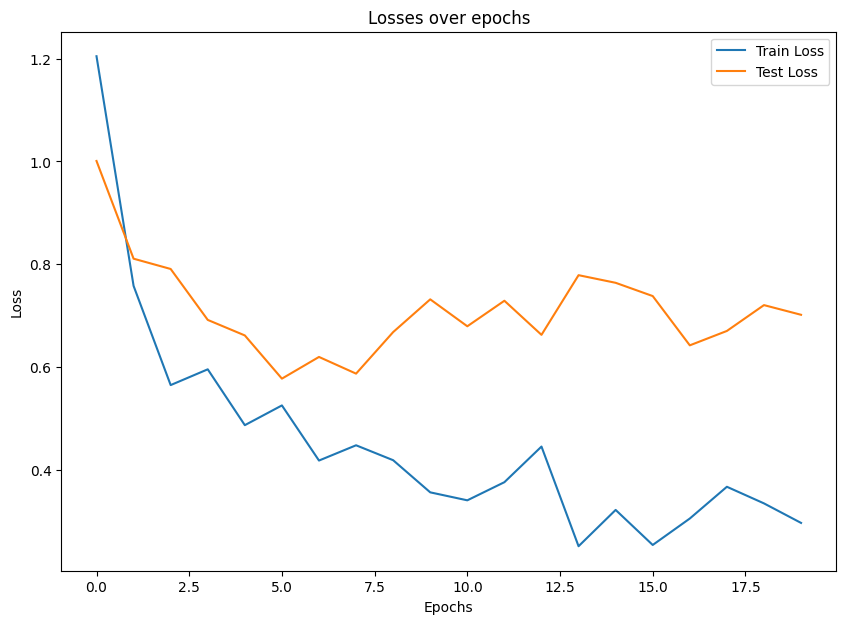

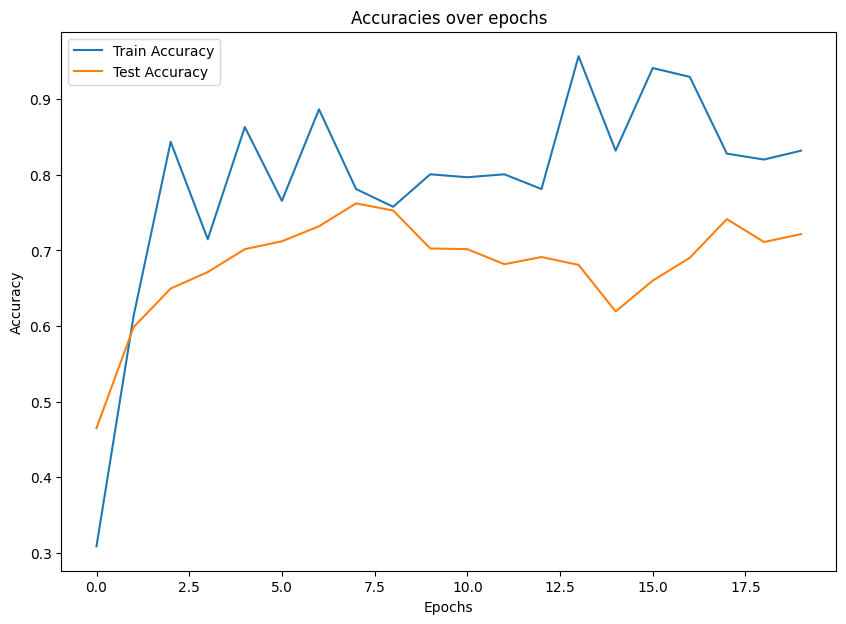

In [32]:
plot_losses(model_1_results["train_loss"], model_1_results["test_loss"])
plot_accuracies(model_1_results["train_acc"], model_1_results["test_acc"])

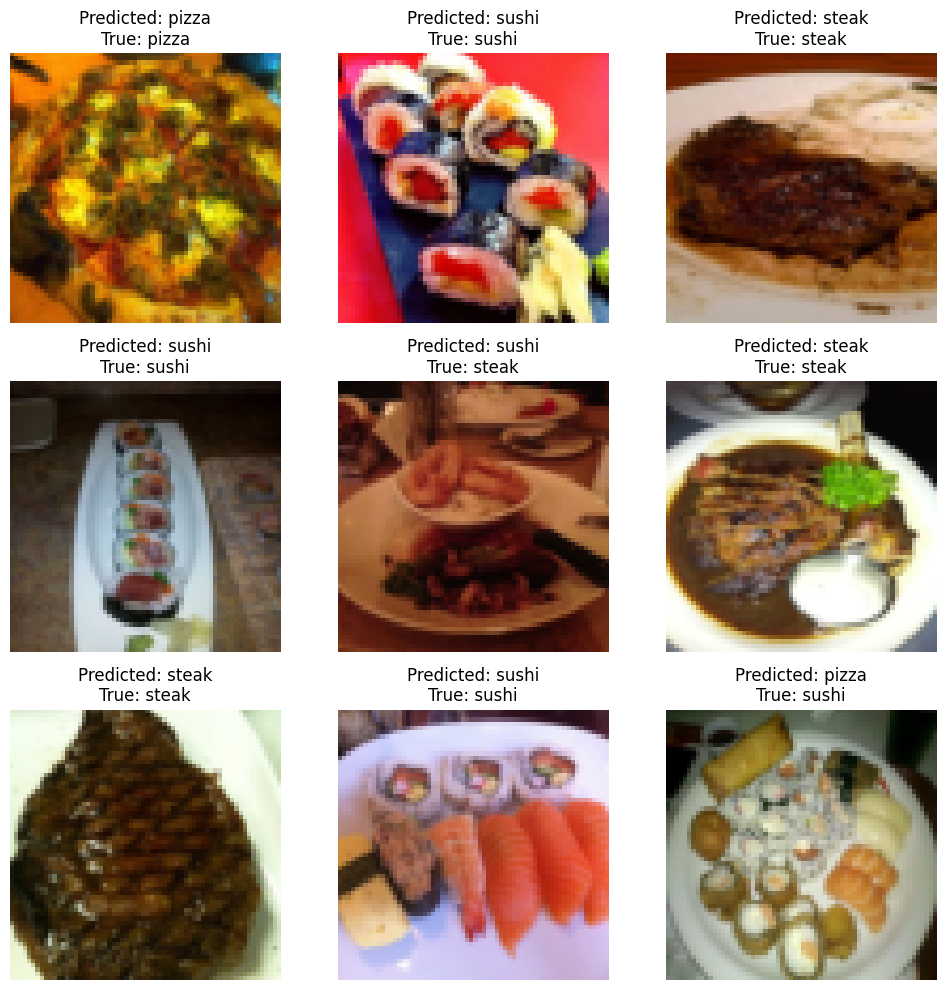

In [33]:
# Plot predictions on test data
plot_predictions(model=model_1,
                 data=test_data,
                 class_names=test_data.classes,
                 num_images=9)

In [34]:
# Now let's try bigger pictures
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_transforms, # transforms to perform on data (images)
                                    target_transform=None) # transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transforms)
NUM_WORKERS = os.cpu_count() # number of workers to use for data loading
assert NUM_WORKERS is not None
train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             shuffle=False,
                             num_workers=NUM_WORKERS)


  5%|▌         | 1/20 [00:01<00:31,  1.68s/it]

Epoch: 1 | train_loss: 0.9036 | train_acc: 0.5312 | test_loss: 0.5748 | test_acc: 0.7850


 10%|█         | 2/20 [00:02<00:25,  1.42s/it]

Epoch: 2 | train_loss: 0.3934 | train_acc: 0.9219 | test_loss: 0.3190 | test_acc: 0.8977


 15%|█▌        | 3/20 [00:04<00:22,  1.34s/it]

Epoch: 3 | train_loss: 0.2911 | train_acc: 0.9414 | test_loss: 0.2617 | test_acc: 0.8977


 20%|██        | 4/20 [00:05<00:20,  1.30s/it]

Epoch: 4 | train_loss: 0.2428 | train_acc: 0.8516 | test_loss: 0.1792 | test_acc: 0.9479


 25%|██▌       | 5/20 [00:06<00:19,  1.27s/it]

Epoch: 5 | train_loss: 0.2192 | train_acc: 0.9727 | test_loss: 0.1922 | test_acc: 0.9176


 30%|███       | 6/20 [00:07<00:17,  1.26s/it]

Epoch: 6 | train_loss: 0.2710 | train_acc: 0.8555 | test_loss: 0.1798 | test_acc: 0.9280


 35%|███▌      | 7/20 [00:09<00:16,  1.25s/it]

Epoch: 7 | train_loss: 0.2113 | train_acc: 0.9648 | test_loss: 0.1811 | test_acc: 0.9280


 40%|████      | 8/20 [00:10<00:14,  1.24s/it]

Epoch: 8 | train_loss: 0.2355 | train_acc: 0.8516 | test_loss: 0.1794 | test_acc: 0.9583


 45%|████▌     | 9/20 [00:11<00:13,  1.24s/it]

Epoch: 9 | train_loss: 0.2355 | train_acc: 0.8555 | test_loss: 0.1764 | test_acc: 0.9280


 50%|█████     | 10/20 [00:12<00:12,  1.24s/it]

Epoch: 10 | train_loss: 0.1470 | train_acc: 0.9883 | test_loss: 0.1879 | test_acc: 0.9280


 55%|█████▌    | 11/20 [00:14<00:11,  1.24s/it]

Epoch: 11 | train_loss: 0.1740 | train_acc: 0.8633 | test_loss: 0.2145 | test_acc: 0.9176


 60%|██████    | 12/20 [00:15<00:09,  1.23s/it]

Epoch: 12 | train_loss: 0.1916 | train_acc: 0.8438 | test_loss: 0.1927 | test_acc: 0.9176


 65%|██████▌   | 13/20 [00:16<00:08,  1.23s/it]

Epoch: 13 | train_loss: 0.2464 | train_acc: 0.8633 | test_loss: 0.2050 | test_acc: 0.9280


 70%|███████   | 14/20 [00:17<00:07,  1.23s/it]

Epoch: 14 | train_loss: 0.1218 | train_acc: 1.0000 | test_loss: 0.2174 | test_acc: 0.9176


 75%|███████▌  | 15/20 [00:18<00:06,  1.23s/it]

Epoch: 15 | train_loss: 0.1732 | train_acc: 0.8711 | test_loss: 0.2360 | test_acc: 0.9176


 80%|████████  | 16/20 [00:20<00:04,  1.23s/it]

Epoch: 16 | train_loss: 0.1235 | train_acc: 0.9922 | test_loss: 0.1805 | test_acc: 0.9375


 85%|████████▌ | 17/20 [00:21<00:03,  1.23s/it]

Epoch: 17 | train_loss: 0.1577 | train_acc: 0.9766 | test_loss: 0.2302 | test_acc: 0.9271


 90%|█████████ | 18/20 [00:22<00:02,  1.23s/it]

Epoch: 18 | train_loss: 0.2533 | train_acc: 0.8633 | test_loss: 0.1660 | test_acc: 0.9375


 95%|█████████▌| 19/20 [00:23<00:01,  1.23s/it]

Epoch: 19 | train_loss: 0.2650 | train_acc: 0.8516 | test_loss: 0.2272 | test_acc: 0.8958


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]

Epoch: 20 | train_loss: 0.2211 | train_acc: 0.8438 | test_loss: 0.1989 | test_acc: 0.9167
Total training time: 25.077 seconds


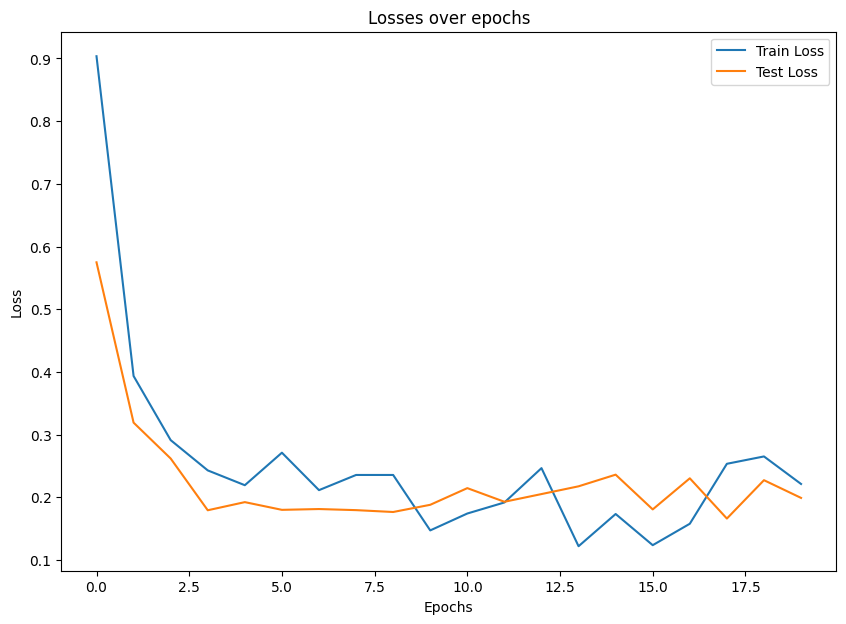

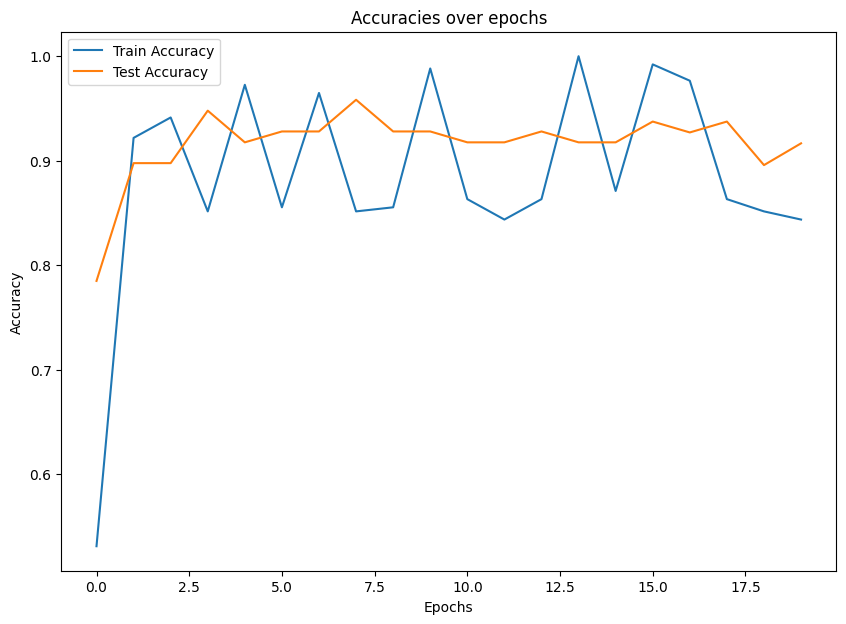

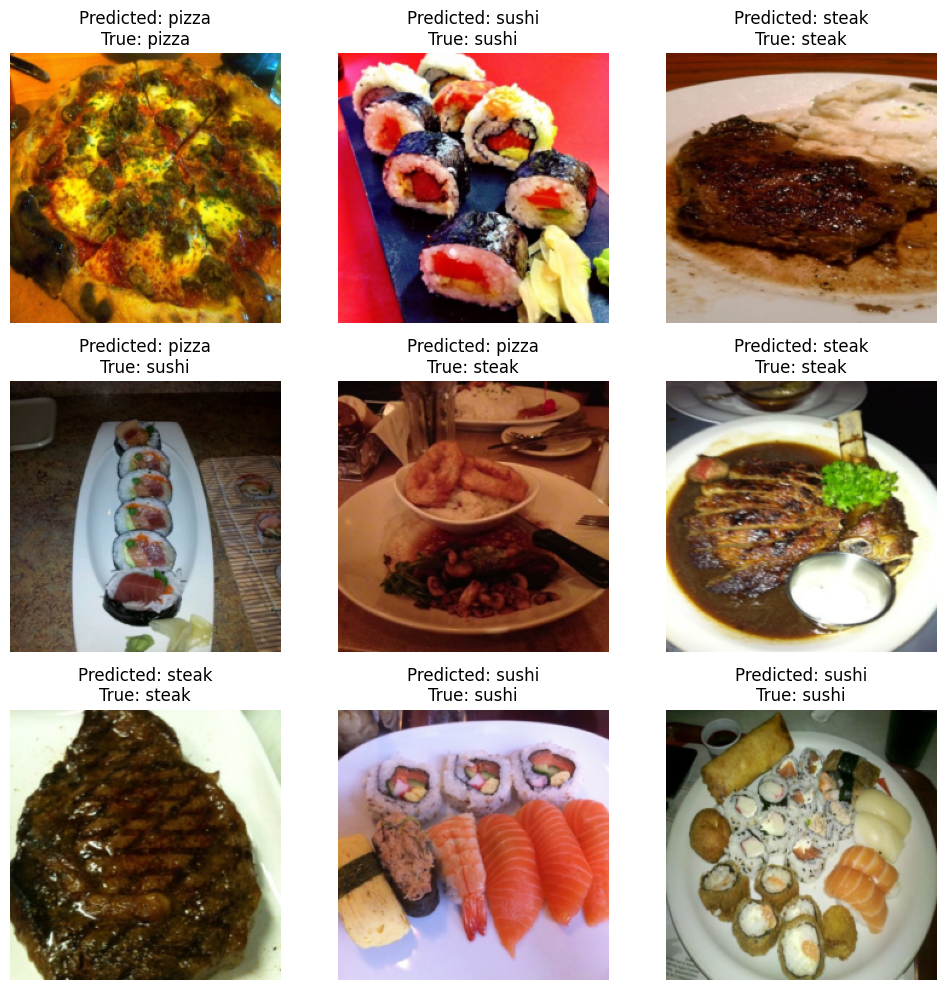

In [35]:
model_2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
# Change the final layer to match our number of classes
model_2.fc = nn.Linear(in_features=model_2.fc.in_features,
                            out_features=len(train_data.classes)).to(device)
# Retrain the model
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.0001)
# Start the timer
start_time = timer()
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_losses(model_2_results["train_loss"], model_2_results["test_loss"])
plot_accuracies(model_2_results["train_acc"], model_2_results["test_acc"])
plot_predictions(model=model_2,
                 data=test_data,
                 class_names=test_data.classes,
                 num_images=9)

  5%|▌         | 1/20 [00:03<01:01,  3.24s/it]

Epoch: 1 | train_loss: 1.0289 | train_acc: 0.6367 | test_loss: 0.9508 | test_acc: 0.6828


 10%|█         | 2/20 [00:06<00:55,  3.08s/it]

Epoch: 2 | train_loss: 0.6801 | train_acc: 0.9688 | test_loss: 0.6153 | test_acc: 0.9072


 15%|█▌        | 3/20 [00:09<00:51,  3.03s/it]

Epoch: 3 | train_loss: 0.4348 | train_acc: 0.9648 | test_loss: 0.3378 | test_acc: 0.9688


 20%|██        | 4/20 [00:12<00:48,  3.00s/it]

Epoch: 4 | train_loss: 0.3050 | train_acc: 0.8594 | test_loss: 0.2455 | test_acc: 0.9384


 25%|██▌       | 5/20 [00:15<00:44,  2.99s/it]

Epoch: 5 | train_loss: 0.2012 | train_acc: 0.9883 | test_loss: 0.2042 | test_acc: 0.9583


 30%|███       | 6/20 [00:18<00:41,  2.99s/it]

Epoch: 6 | train_loss: 0.1403 | train_acc: 0.9844 | test_loss: 0.1932 | test_acc: 0.9583


 35%|███▌      | 7/20 [00:21<00:38,  2.98s/it]

Epoch: 7 | train_loss: 0.2403 | train_acc: 0.8711 | test_loss: 0.2009 | test_acc: 0.9489


 40%|████      | 8/20 [00:24<00:35,  3.00s/it]

Epoch: 8 | train_loss: 0.1258 | train_acc: 1.0000 | test_loss: 0.1925 | test_acc: 0.9384


 45%|████▌     | 9/20 [00:27<00:32,  2.99s/it]

Epoch: 9 | train_loss: 0.1254 | train_acc: 0.9961 | test_loss: 0.2003 | test_acc: 0.9384


 50%|█████     | 10/20 [00:30<00:29,  2.99s/it]

Epoch: 10 | train_loss: 0.2114 | train_acc: 0.8633 | test_loss: 0.1951 | test_acc: 0.9384


 55%|█████▌    | 11/20 [00:33<00:26,  2.98s/it]

Epoch: 11 | train_loss: 0.2096 | train_acc: 0.8711 | test_loss: 0.1874 | test_acc: 0.9688


 60%|██████    | 12/20 [00:35<00:23,  2.98s/it]

Epoch: 12 | train_loss: 0.1530 | train_acc: 0.8711 | test_loss: 0.1764 | test_acc: 0.9688


 65%|██████▌   | 13/20 [00:38<00:20,  2.98s/it]

Epoch: 13 | train_loss: 0.0826 | train_acc: 1.0000 | test_loss: 0.1830 | test_acc: 0.9792


 70%|███████   | 14/20 [00:41<00:17,  2.97s/it]

Epoch: 14 | train_loss: 0.2202 | train_acc: 0.8594 | test_loss: 0.2090 | test_acc: 0.9688


 75%|███████▌  | 15/20 [00:44<00:14,  2.97s/it]

Epoch: 15 | train_loss: 0.0911 | train_acc: 0.9922 | test_loss: 0.1778 | test_acc: 0.9583


 80%|████████  | 16/20 [00:47<00:11,  2.97s/it]

Epoch: 16 | train_loss: 0.1743 | train_acc: 0.8711 | test_loss: 0.1775 | test_acc: 0.9688


 85%|████████▌ | 17/20 [00:50<00:08,  2.97s/it]

Epoch: 17 | train_loss: 0.1087 | train_acc: 1.0000 | test_loss: 0.2137 | test_acc: 0.9489


 90%|█████████ | 18/20 [00:53<00:05,  2.96s/it]

Epoch: 18 | train_loss: 0.2557 | train_acc: 0.8672 | test_loss: 0.1714 | test_acc: 0.9583


 95%|█████████▌| 19/20 [00:56<00:02,  2.96s/it]

Epoch: 19 | train_loss: 0.1158 | train_acc: 1.0000 | test_loss: 0.1677 | test_acc: 0.9479


100%|██████████| 20/20 [00:59<00:00,  2.99s/it]

Epoch: 20 | train_loss: 0.1075 | train_acc: 1.0000 | test_loss: 0.1655 | test_acc: 0.9688
Total training time: 59.711 seconds


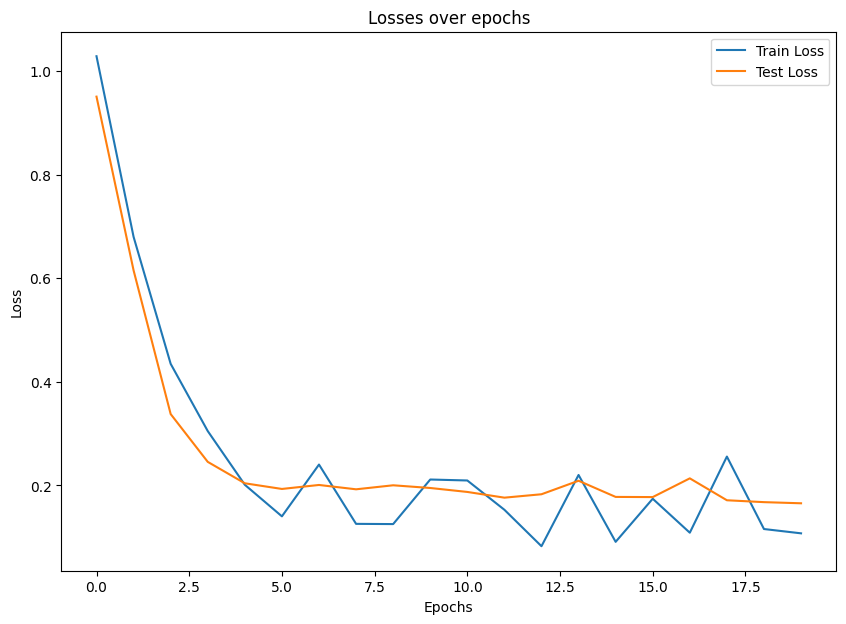

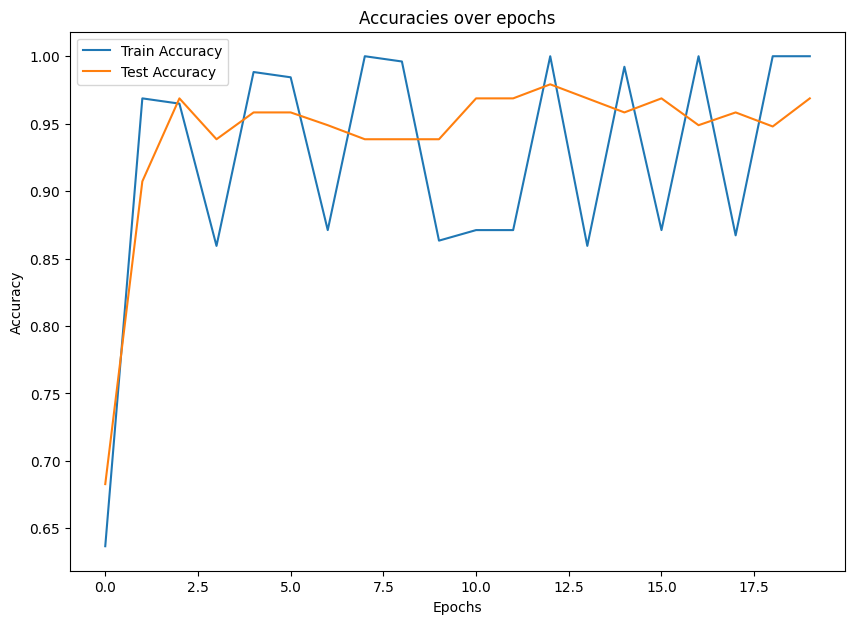

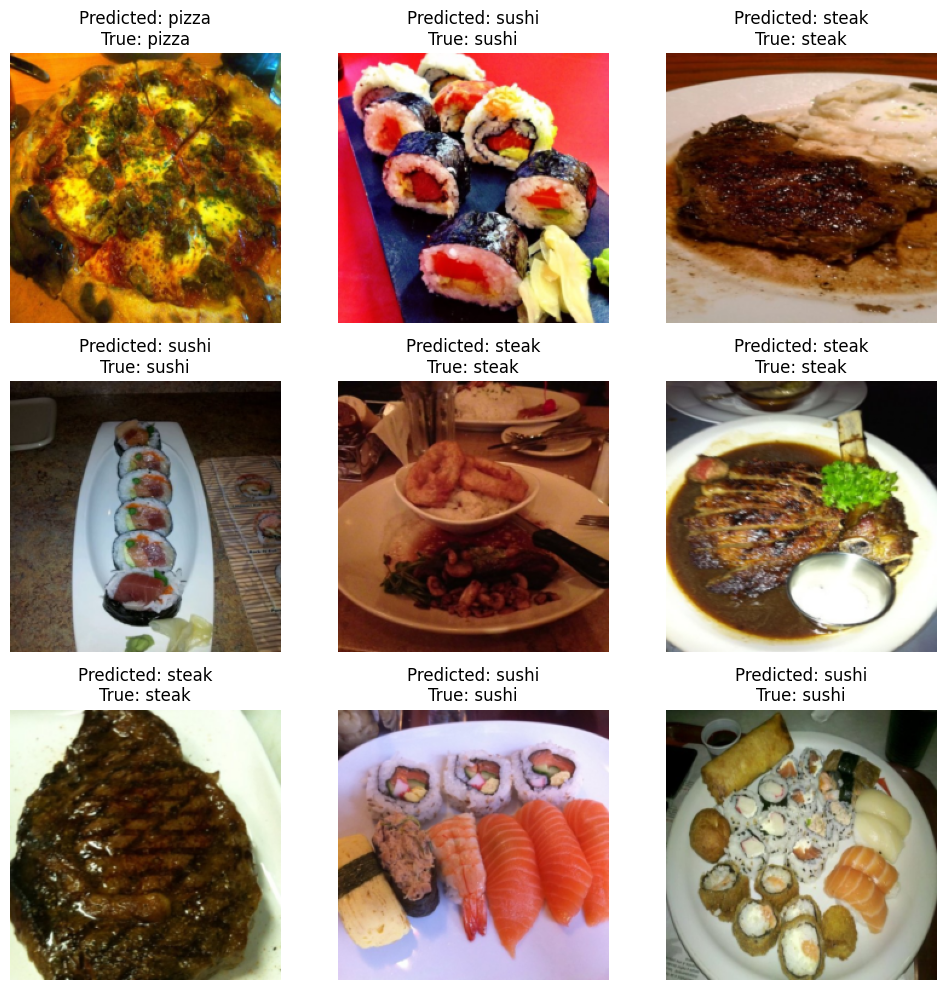

In [36]:
# Now let's try a much bigger model
model_3 = models.resnet152(weights=models.ResNet152_Weights.DEFAULT).to(device)
# Change the final layer to match our number of classes
model_3.fc = nn.Linear(in_features=model_3.fc.in_features,
                            out_features=len(train_data.classes)).to(device)
# Retrain the model
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.0001)
# Start the timer
start_time = timer()
model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_losses(model_3_results["train_loss"], model_3_results["test_loss"])
plot_accuracies(model_3_results["train_acc"], model_3_results["test_acc"])
plot_predictions(model=model_3,
                 data=test_data,
                 class_names=test_data.classes,
                 num_images=9)